In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

pd.set_option('max_colwidth', 200)
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

In [2]:
from const import *
import train_reorder_size_model, train_none_order_model
import utils, predict

/home/damonhao/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
reload(train_none_order_model)

<module 'train_none_order_model' from 'train_none_order_model.py'>

In [30]:
df_train = pd.read_csv('../reorder_size_input/train.csv')

In [31]:
df_validate = pd.read_csv('../reorder_size_input/validate.csv')

In [32]:
df_all_train = utils.concat([df_train, df_validate])

In [33]:
df_all_train_not_none = df_all_train[df_all_train.reorder_size != 0]

In [30]:
df_all_train_not_none[df_all_train_not_none.days_since_prior_order == 30].shape[0] / float(df_all_train_not_none.shape[0])

0.29214482044255224

In [32]:
df_all_train_none = df_all_train[df_all_train.reorder_size == 0]

In [34]:
df_all_train_none[df_all_train_none.last_size == 0].shape[0] / float(df_all_train_none.shape[0])

0.28063241106719367

In [35]:
df_all_train_not_none[df_all_train_not_none.last_size == 0].shape[0] / float(df_all_train_not_none.shape[0])

0.05655468284845074

In [13]:
df_prior = pd.read_csv('../reorder_size_input/prior_orders_extend.csv')

In [66]:
df_prior[df_prior.user_id ==540].sort_values('order_number', ascending=False)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder_size
8215,2940154,540,5,4,11,3.0,1
8214,1755983,540,4,1,3,14.0,0
8213,3171527,540,3,1,15,4.0,1
8212,2240087,540,2,4,12,19.0,0
8211,2308775,540,1,6,16,NaN,0


In [38]:
df_train_none_prior = df_prior[df_prior.user_id.isin(df_all_train_none.user_id)]

In [3]:
df_prior_orders_extend = pd.read_csv(NONE_ORDER_INPUT_DIR+'prior_orders_extend.csv', index_col=0)

In [6]:
df_prior_orders_extend.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder_size,order_size,order_product_count,reorder_ratio
0,2539329,1,1,2,8,NaN,0,5,5,0.000
1,2398795,1,2,3,7,15.0,3,6,6,0.500
2,473747,1,3,3,12,21.0,3,5,5,0.600
3,2254736,1,4,4,7,29.0,5,5,5,1.000
4,431534,1,5,4,15,28.0,5,8,8,0.625


In [8]:
df_prior_orders_extend = df_prior_orders_extend.drop(['order_product_count'], axis=1)

In [9]:
df_prior_orders_extend.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder_size,order_size,reorder_ratio
0,2539329,1,1,2,8,NaN,0,5,0.000
1,2398795,1,2,3,7,15.0,3,6,0.500
2,473747,1,3,3,12,21.0,3,5,0.600
3,2254736,1,4,4,7,29.0,5,5,1.000
4,431534,1,5,4,15,28.0,5,8,0.625


In [10]:
df_prior_orders_extend.to_csv(NONE_ORDER_INPUT_DIR+'prior_orders_extend.csv', index=False)

## 历史订单少的，none order 的可能性高。

In [39]:
df_train_none_prior_order_count = df_train_none_prior.groupby(UID).size()

In [44]:
df_train_none_prior_order_count.describe()

count    8602.000000
mean        8.317368
std         9.334697
min         3.000000
25%         3.000000
50%         5.000000
75%         9.000000
max        99.000000
dtype: float64

In [75]:
df_train_none_prior_order_count.reset_index().rename(columns={0: 'products'}).head()

,user_id,products
0,10,5
1,44,3
2,47,5
3,93,14
4,112,26


In [45]:
df_train_not_none_prior = df_prior[df_prior.user_id.isin(df_all_train_not_none.user_id)]

In [46]:
df_train_not_none_prior_order_count = df_train_not_none_prior.groupby(UID).size()

In [47]:
df_train_not_none_prior_order_count.describe()

count    122607.000000
mean         16.115157
std          16.940131
min           3.000000
25%           5.000000
50%          10.000000
75%          20.000000
max          99.000000
dtype: float64

## none order 的 prior 的 reorder size 的分布

In [60]:
df_train_none_prior.reorder_size.describe()

count    71546.000000
mean         2.339698
std          3.339566
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         50.000000
Name: reorder_size, dtype: float64

In [64]:
df_train_none_prior.shape

(71546, 7)

In [65]:
df_train_not_none_prior.reorder_size.describe()

count    1.975831e+06
mean     6.073361e+00
std      5.856280e+00
min      0.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      9.000000e+00
max      1.300000e+02
Name: reorder_size, dtype: float64

In [24]:
df_corr = pd.read_csv('../none_order_input/corr.csv', index_col=0)

In [29]:
df_corr.last_3_reorder_size_mean

order_id                                    0.004702
user_id                                    -0.004943
order_number                                0.319815
order_dow                                  -0.023550
order_hour_of_day                          -0.006103
days_since_prior_order                     -0.175093
label                                      -0.195746
last_size                                   0.876642
last_order_none                            -0.249283
last_3_none_order_count                    -0.433485
last_3_none_order_ratio                    -0.433485
last_3_order_dow_mean                      -0.044804
last_3_order_dow_std                       -0.015473
last_3_order_hour_of_day_mean              -0.017741
last_3_order_hour_of_day_std                0.006430
last_3_order_days_since_prior_order_mean   -0.209795
last_3_order_days_since_prior_order_std    -0.124447
last_3_order_days_since_prior_order_max    -0.214010
last_3_order_days_since_prior_order_min    -0.

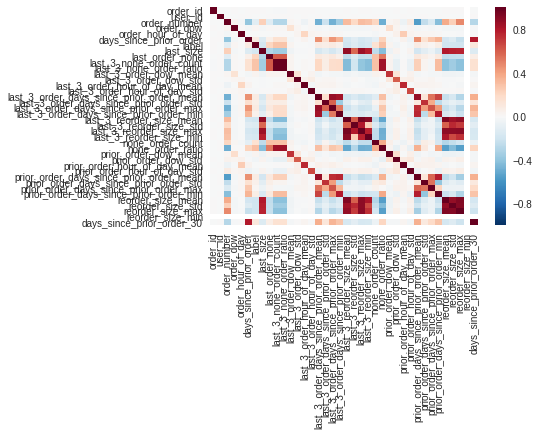

In [26]:
sns.heatmap(df_corr)

## 模型特征

In [ ]:
xgb_model = train_none_order_model.run_train(NONE_ORDER_INPUT_DIR+'train.csv', NONE_ORDER_INPUT_DIR + 'validate.csv')

In [20]:
df_f_gain = utils.get_feature_score(xgb_model._Booster.get_score(importance_type='gain'))

In [21]:
df_f_gain

,features,scores
0,reorder_size_mean,215.430447
1,reorder_size_max,141.082389
2,last_3_reorder_size_max,101.874139
3,last_3_reorder_size_min,54.040934
4,none_order_ratio,30.967638
5,last_order_none,24.777993
6,last_size,21.711409
7,days_since_prior_order_30,20.576883
8,last_3_none_order_count,20.359425
9,days_since_prior_order,14.447138


In [15]:
xgb_model_imbalance = utils.load_model('XGBClassifier_colsample_bytree:0.9_learning_rate:0.03_max_depth:4_n_estimators:351_subsample:0.8_08-06-13-21-10.pkl')

In [16]:
df_f_gain_imba = utils.get_feature_score(xgb_model_2._Booster.get_score(importance_type='gain'))

In [17]:
df_f_gain_imba

,features,scores
0,reorder_size_mean,174.414057
1,last_3_reorder_size_max,50.420780
2,last_3_reorder_size_min,50.011998
3,none_order_ratio,29.600190
4,last_order_none,20.681271
5,last_size,19.595445
6,last_3_none_order_count,16.098053
7,prior_order_days_since_prior_order_mean,13.323452
8,prior_order_days_since_prior_order_min,13.018807
9,reorder_size_max,12.903322


In [30]:
df_f_weight = utils.get_feature_score(xgb_model._Booster.get_score(importance_type='weight'))

In [36]:
df_f_cover = utils.get_feature_score(xgb_model._Booster.get_score(importance_type='cover'))

In [10]:
df_validate = pd.read_csv('../none_order_input/validate.csv')

In [84]:
df_validate.to_csv('../none_order_input/validate.csv', index=False)

In [6]:
df_validate['label'] = df_validate['reorder_size'].map(lambda x: 1 if x == 0 else 0)

In [25]:
(df_validate.reorder_size_min > 0).sum()

0

In [24]:
df_validate.shape

(26390, 38)

In [12]:
df_validate_none = df_validate[df_validate.label == 1]

In [32]:
df_predict_proba = pd.read_csv('../prediction/validate_none_order_proba.csv')

In [35]:
df_predict_proba.label.sum()

1773

In [38]:
df_predict_proba.label.sum() / float(df_validate.shape[0])

0.0671845395983327

In [41]:
name = 'XGBClassifier_colsample_bytree:0.9_learning_rate:0.024_max_depth:4_n_estimators:345_scale_pos_weight:14_subsample:0.8_08-06-15-43-38.pkl'
xgb_model_scale = utils.load_model(name)

In [44]:
df_f_gain1 = utils.get_feature_score(xgb_model_scale._Booster.get_score(importance_type='gain'))

In [46]:
df_analysis = predict.read_max_f1_analysis('../prediction/analysis_08-04-20-56-54_validate_diff_stack.csv')

In [47]:
none_index = df_analysis.apply(lambda row: True if row['true_products'][0] is None else False, axis=1)
df_analysis_none =df_analysis[none_index]

In [48]:
df_analysis_none[df_analysis_none.scores == 0].head()

,user_id,true_products,products,best_k_proba,scores
349,184141,[None],"[46842, 2374, 20682, 20156, 11422, 29095, 41164]",[ 0.92306 0.92181 0.90807 0.89322 0.86663 0.86586 0.81029],0.0
460,178114,[None],"[19660, 37710]",[ 0.92231 0.66953],0.0
869,179619,[None],[21386],[ 0.92013],0.0
1042,170686,[None],"[13176, 37710, 13259, 39275, 32403]",[ 0.91933 0.91802 0.89533 0.89492 0.80209],0.0
1091,184273,[None],"[14947, 40013, 8424, 27705, 23821]",[ 0.91906 0.89742 0.85488 0.85124 0.84982],0.0


In [58]:
df_target = df_predict_proba[df_predict_proba.user_id.isin(df_analysis_none[df_analysis_none.scores == 0].user_id)]  

In [9]:
df_predict_1 = pd.read_csv('../prediction/validate_none_order_prob_ratio.csv')

In [10]:
df_predict_1.head(30)

,user_id,label,proba
0,182928,1,0.861438
1,191168,1,0.860640
2,205809,0,0.859323
3,182866,0,0.857982
4,204186,0,0.853473
5,184407,0,0.851065
6,192176,0,0.849627
7,191016,0,0.846939
8,189364,1,0.846523
9,183360,0,0.841807


In [11]:
df_predict_2 = pd.read_csv('../prediction/validate_none_order_proba_bag.csv')

In [14]:
df_predict_2.tail()

,user_id,label,proba
26385,197693,0,0.012315
26386,188965,0,0.012255
26387,177610,0,0.012100
26388,195545,0,0.011090
26389,181139,0,0.009357
